# Load Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from yellowbrick.classifier import classification_report, confusion_matrix
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

# Import Data

In [9]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

X_pred = pd.read_csv("TEST_KAGGLE.csv", index_col="Id")

#full training set
X = pd.concat([X_train, X_valid, X_test], axis=0)
y = pd.concat([y_train, y_valid, y_test], axis=0)

In [10]:
y_train = np.array(y_train)
y_train = y_train.ravel()

y = np.array(y)
y = y.ravel()

# Decision Trees

## Create full tree

In [57]:
tree_full = DecisionTreeClassifier(criterion='entropy')#gini entropy
tree_full.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

## Plot Full tree

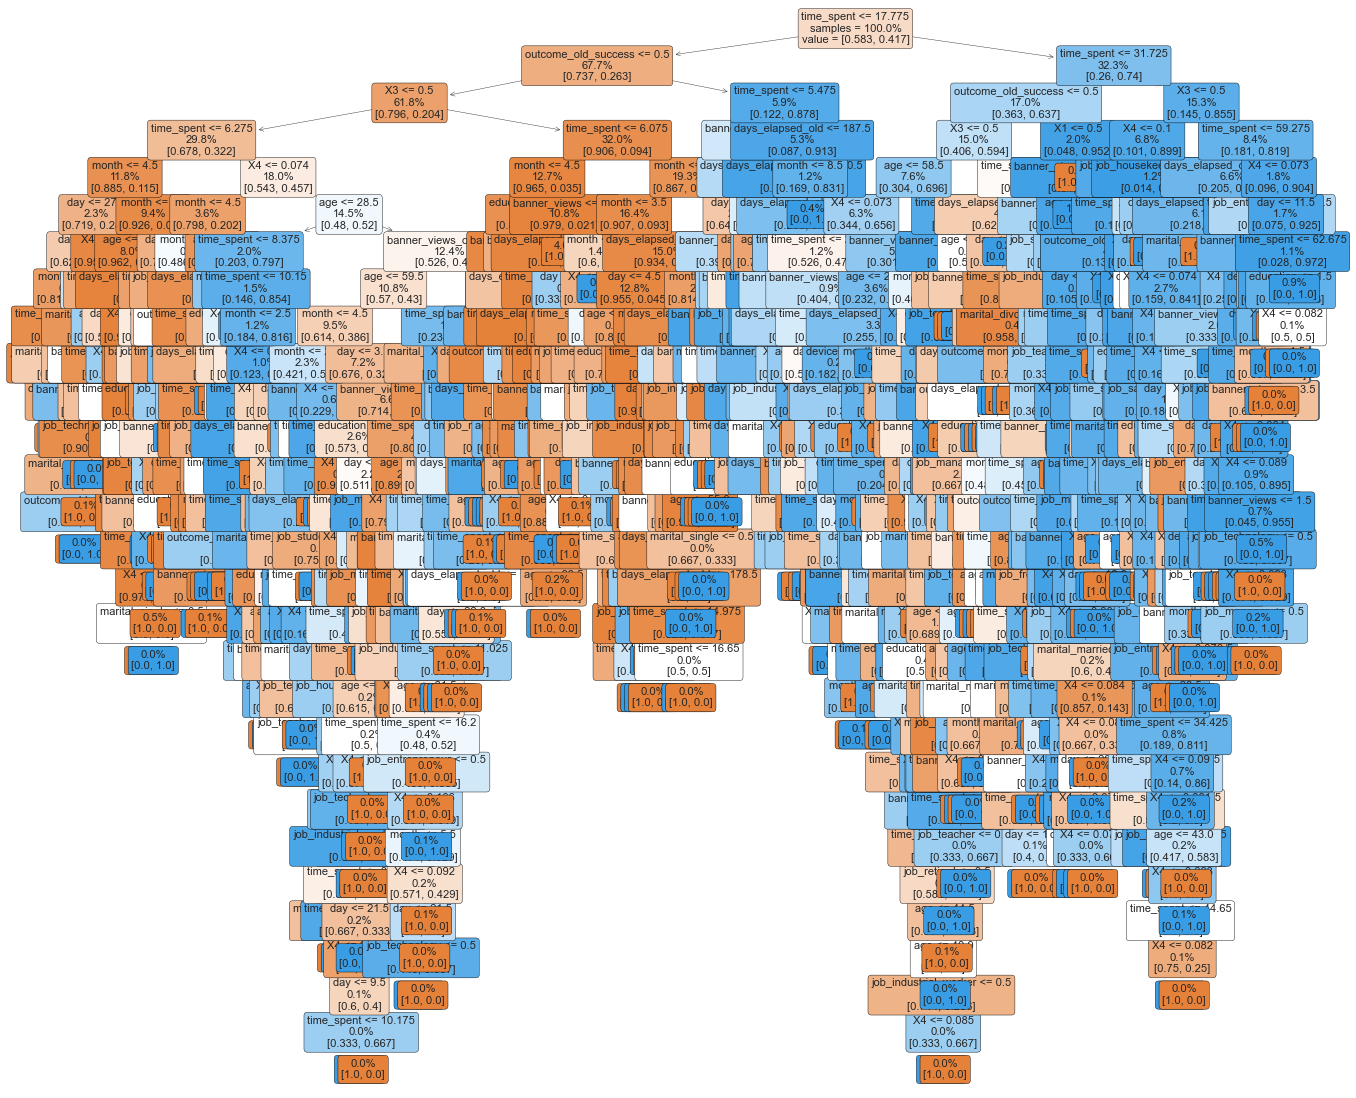

In [58]:
plt.figure(figsize=(16,14))
plot_tree(tree_full, feature_names=X_train.columns.tolist(), impurity=False, label="root",
          filled=True, proportion=True, rounded=True, fontsize=8)
#filled is for adding color
#rounded is for edges
#proportion is to give the amount in relative numbers
plt.show()

## Measure Error

In [59]:
#fully grown tree is like k nearest neighbor with 1 neighbor
print("Train accuracy:", tree_full.score(X_train,y_train))
print("Validation accuracy:", tree_full.score(X_valid,y_valid))
print("Test accuracy:", tree_full.score(X_test,y_test))


Train accuracy: 1.0
Validation accuracy: 0.7907669396872673
Test accuracy: 0.7751303052866716


## Find Best tree

In [60]:
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
#this function applies penalized fitting. slide 10 of the presentation.
#changes the value of alpha so that it prunes the tre and it returns values where the splits actually change

ccp_alphas, impurities = path.ccp_alphas, path.impurities #store to variables

In [61]:
grid_alphas = ccp_alphas
grid_alphas = np.logspace(-5,1,100) 

In [62]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 69)
tree_full = DecisionTreeClassifier(criterion = "entropy", ccp_alpha = 0)
hyper_params = {"ccp_alpha": grid_alphas}

#no need to scale as the data as the splits do not depend on the comparison between variable range
treeCV = GridSearchCV(estimator = tree_full,
                      scoring = "accuracy",
                      param_grid = hyper_params,
                      cv = folds)

In [63]:
treeCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=69, shuffle=True),
             estimator=DecisionTreeClassifier(ccp_alpha=0, criterion='entropy'),
             param_grid={'ccp_alpha': array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
       3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
       5.3366992...
       4.03701726e-01, 4.64158883e-01, 5.33669923e-01, 6.13590727e-01,
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01])},
             scoring='accuracy')

In [64]:
pd.DataFrame(treeCV.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036165,0.003587,0.003218,0.000913,0.00001,{'ccp_alpha': 1e-05},0.791069,0.746411,0.763955,0.787879,0.799043,0.808612,0.753994,0.801917,0.814696,0.779553,0.784713,0.022114,34
1,0.036328,0.003931,0.003218,0.000739,0.000011,{'ccp_alpha': 1.1497569953977357e-05},0.783094,0.741627,0.771930,0.787879,0.803828,0.799043,0.763578,0.793930,0.805112,0.774760,0.782478,0.018974,45
2,0.045051,0.019860,0.003335,0.000811,0.000013,{'ccp_alpha': 1.3219411484660286e-05},0.791069,0.773525,0.771930,0.792663,0.805423,0.811802,0.755591,0.789137,0.803514,0.774760,0.786941,0.016809,23
3,0.038509,0.004795,0.003103,0.001028,0.000015,{'ccp_alpha': 1.5199110829529332e-05},0.789474,0.744817,0.771930,0.792663,0.795853,0.818182,0.758786,0.798722,0.813099,0.773163,0.785669,0.022099,28
4,0.037124,0.005722,0.002985,0.000574,0.000017,{'ccp_alpha': 1.747528400007683e-05},0.792663,0.760766,0.771930,0.791069,0.799043,0.824561,0.758786,0.795527,0.806709,0.777955,0.787901,0.019623,18


In [65]:
resCV = treeCV.cv_results_

test_Misclasif = 1 - resCV["mean_test_score"]
std_mean_err_test = resCV["std_test_score"] / np.sqrt(10)
alpha_grid = resCV["param_ccp_alpha"].data

index_best = treeCV.best_index_
best_alpha = treeCV.best_params_["ccp_alpha"]
#need to check that the misclassification error is smaller than a threshold
one_se_rule_best_alpha = np.max(alpha_grid[test_Misclasif <= test_Misclasif[index_best] + std_mean_err_test[index_best]])

print("Best alpha:", best_alpha)
print("Best 1se alpha:", one_se_rule_best_alpha)

Best alpha: 0.0015199110829529332
Best 1se alpha: 0.0023101297000831605


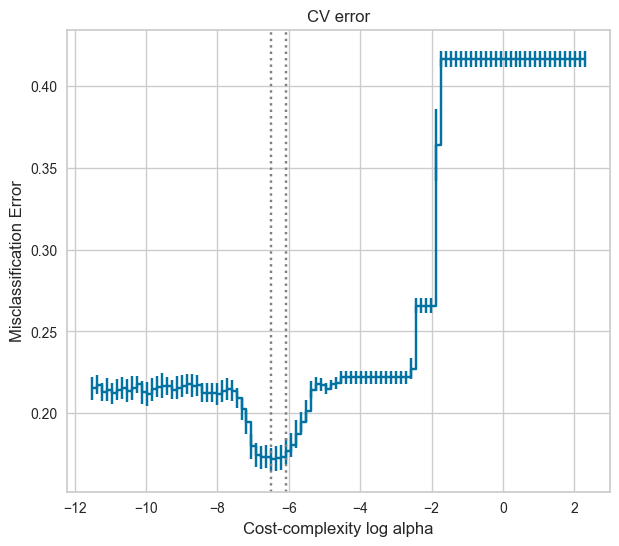

In [66]:
plt.figure(figsize=(7,6))
plt.errorbar(x=np.log(grid_alphas), y=test_Misclasif, yerr=std_mean_err_test, capsize=3, drawstyle="steps-post")#, fmt='o'

plt.axvline(np.log(best_alpha), ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(np.log(one_se_rule_best_alpha), ls='dotted', color="grey")#vertical line at best k value according to 1 std err rule

plt.title("CV error")
plt.xlabel('Cost-complexity log alpha')
plt.ylabel('Misclassification Error')
plt.show()

## Create Best Tree


In [67]:
#tree_best = treeCV.best_estimator_
#or:
tree_best_1se = DecisionTreeClassifier(criterion='entropy', ccp_alpha=one_se_rule_best_alpha).fit(X_train,y_train)
tree_best = DecisionTreeClassifier(criterion='entropy', ccp_alpha=best_alpha).fit(X_train,y_train)

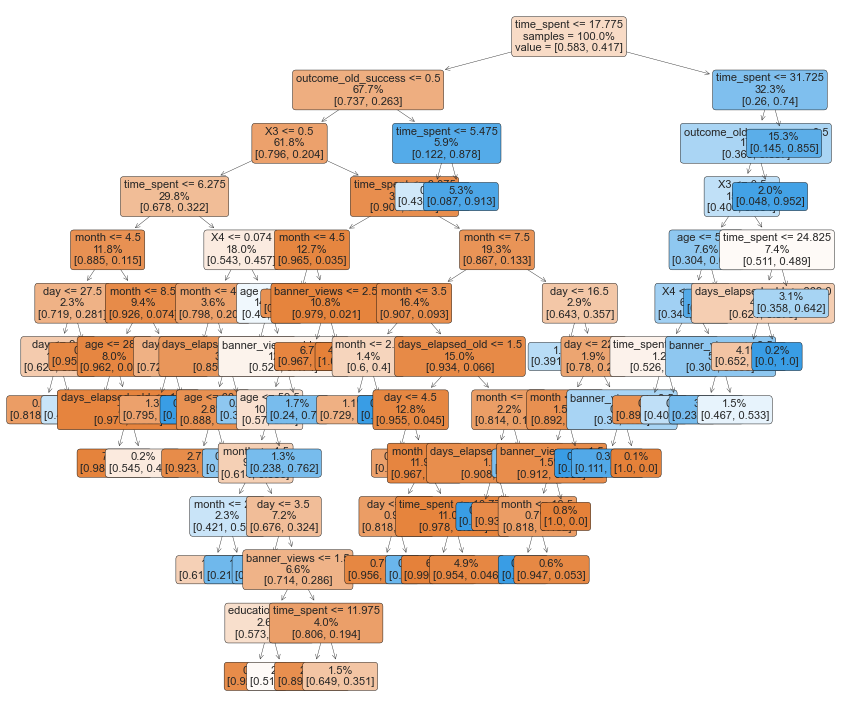

In [68]:
plt.figure(figsize=(10,9))
plot_tree(tree_best, feature_names=X_train.columns.tolist(), impurity=False, label="root",
          filled=True, proportion=True, rounded=True, fontsize=8)
plt.show()

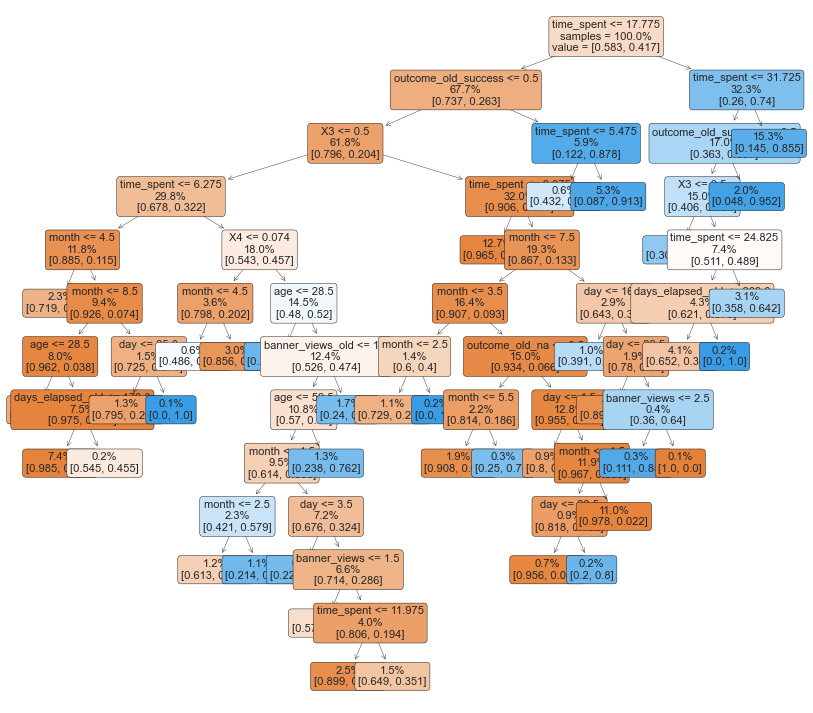

In [69]:
plt.figure(figsize=(10,9))
plot_tree(tree_best_1se, feature_names=X_train.columns.tolist(), impurity=False, label="root",
          filled=True, proportion=True, rounded=True, fontsize=8)
plt.show()

In [70]:
#feature importance
tree_best.feature_importances_

array([0.03604528, 0.00416277, 0.        , 0.04662783, 0.10806366,
       0.45081848, 0.02130986, 0.00977309, 0.0270245 , 0.        ,
       0.        , 0.08741618, 0.02200332, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18675504,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

## Measure error for Best Tree

In [71]:
#fully grown tree is like k nearest neighbor with 1 neighbor
print("Train accuracy:", tree_best.score(X_train,y_train))
print("Validation accuracy:", tree_best.score(X_valid,y_valid))
print("Test accuracy:", tree_best.score(X_test,y_test))

Train accuracy: 0.8495052665177146
Validation accuracy: 0.8160833953834699
Test accuracy: 0.8451228592702904


In [72]:
#fully grown tree is like k nearest neighbor with 1 neighbor
print("Train accuracy:", tree_best_1se.score(X_train,y_train))
print("Validation accuracy:", tree_best_1se.score(X_valid,y_valid))
print("Test accuracy:", tree_best_1se.score(X_test,y_test))

Train accuracy: 0.8428024257899777
Validation accuracy: 0.8145941921072226
Test accuracy: 0.8436336559940432


In [73]:
y_pred = tree_best.predict(X_valid)
y_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

# Bagging/ Random Forest

In [151]:
rfc = RandomForestClassifier(n_estimators=1000, oob_score=True, max_features=8,
                             min_samples_leaf=1, warm_start=False, random_state=1, n_jobs=-2)
rfc.fit(X_train, y_train)


C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\4293659782.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(max_features=8, n_estimators=1000, n_jobs=-2,
                       oob_score=True, random_state=1)

In [152]:
rfc.oob_score_

0.8538142355569741

In [76]:
#Defaut "recommended" value for the hyper-parameter m
#(m=nb of variables randomly chosen to be considered at each split in each tree)
default_max_features_param = np.sqrt(X_train.shape[1])
default_max_features_param

5.5677643628300215

## Random Forest

In [77]:
hyperparam_grid={"max_features":[2, 3, 4, 5, 6, 7, 8],
                 'min_samples_leaf':[1, 3, 5, 7, 9, 11, 13]}

In [78]:
from sklearn.model_selection import ParameterGrid

rfc = RandomForestClassifier(n_estimators=2000, oob_score=True,
                             warm_start=False, random_state=1, n_jobs=-2)
best_score=0.5

for g in ParameterGrid(hyperparam_grid):
    rfc.set_params(**g)
    #or rfc.set_params(min_samples_leaf=g['min_samples_leaf'], max_features=g['max_features'])
    rfc.fit(X_train,y_train)
    # save if best
    if rfc.oob_score_ > best_score:
        best_score = rfc.oob_score_
        best_params = g

print(f"OOB: %0.5f" % best_score)
print("Best parameters:", best_params)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\1102910452.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\1102910452.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\1102910452.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\1102910452.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


OOB: 0.85286
Best parameters: {'max_features': 8, 'min_samples_leaf': 1}


In [81]:
rfc = RandomForestClassifier(n_estimators=5000, max_features=best_params['max_features'],
                             min_samples_leaf=best_params['min_samples_leaf'], criterion="entropy",
                             oob_score=True, warm_start=False, random_state=1)

rfc.fit(X_train, y_train)

y_valid_pred = rfc.predict(X_valid)
y_test_pred = rfc.predict(X_test)



C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\3662303916.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [83]:
print(rfc.oob_score_)
print(rfc.score(X_valid, y_valid))
print(rfc.score(X_test, y_test))

0.8530162783274816
0.8376768428890543
0.8488458674609084


In [25]:
#set hyperparameter grid
rf_hyperparam_grid={"max_features":[3, 4, 5, 6, 7, 8],
                 'min_samples_leaf':[1, 5, 10, 15, 20, 25],
                 "n_estimators":[100, 125, 150, 200, 225, 250]}

#instantiate the randfortest
rfc = RandomForestClassifier(criterion = "log_loss", oob_score=True, warm_start=False, random_state=1, n_jobs=-2)
best_score=0.5

#loop over parameters. running duration 24mins.
for rfg in ParameterGrid(rf_hyperparam_grid):
    rfc.set_params(**rfg)
    rfc.fit(X_train,y_train)
    # save if best
    if rfc.oob_score_ > best_score:
        best_rfc_score = rfc.oob_score_
        best_rfc_params = rfg

#print best results
print(f"OOB: %0.5f" % best_rfc_score)
print("Best parameters:", best_rfc_params)

OOB: 0.83833
Best parameters: {'max_features': 8, 'min_samples_leaf': 25, 'n_estimators': 250}


In [26]:
rfc = RandomForestClassifier(n_estimators=best_rfc_params["n_estimators"], 
                             max_features=best_rfc_params["max_features"],
                             min_samples_leaf=best_rfc_params["min_samples_leaf"], 
                             criterion="log_loss",oob_score=True, warm_start=False, random_state=1)



#Print the results
print("Random Forest Best Model")
print(" ")

#fit and predict on partitioned data set
rfc.fit(X_train,y_train)
print("Training accuracy:", round(rfc.oob_score_,4))
print("Validation accuracy:", round(rfc.score(X_valid, y_valid),4))
print("Test accuracy:", round(rfc.score(X_test, y_test),4))
print("X accuracy for Partially Trained Model:", round(rfc.score(X, y),4))

#fit and predict on all data
rfc.fit(X,y)
print("X accuracy on Fully Trained Model:", round(rfc.score(X, y),4))

Random Forest Best Model
 
Training accuracy: 0.8383
Validation accuracy: 0.8146
Test accuracy: 0.8459
X accuracy for Partially Trained Model: 0.8477
X accuracy on Fully Trained Model: 0.8572


### Without Entropy

In [84]:
rfc = RandomForestClassifier(n_estimators=2000, max_features=best_params['max_features'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             oob_score=True, warm_start=False, random_state=69)

rfc.fit(X_train, y_train)

y_valid_pred = rfc.predict(X_valid)
y_test_pred = rfc.predict(X_test)

y_valid_proba = rfc.predict_proba(X_valid)
y_test_proba = rfc.predict_proba(X_test)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\4150413974.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [85]:
print(rfc.oob_score_)
print(rfc.score(X_valid, y_valid))
print(rfc.score(X_test, y_test))

0.8549313756782636
0.8369322412509308
0.845867460908414


### With Entropy

In [86]:
rfc = RandomForestClassifier(n_estimators=2000, max_features=best_params['max_features'],
                             min_samples_leaf=best_params['min_samples_leaf'], criterion="entropy",
                             oob_score=True, warm_start=False, random_state=69)

rfc.fit(X_train, y_train)

y_valid_pred = rfc.predict(X_valid)
y_test_pred = rfc.predict(X_test)

y_valid_proba = rfc.predict_proba(X_valid)
y_test_proba = rfc.predict_proba(X_test)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\254599956.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [87]:
print(rfc.oob_score_)
print(rfc.score(X_valid, y_valid))
print(rfc.score(X_test, y_test))

0.8538142355569741
0.8369322412509308
0.8466120625465376


## ROC AUC

In [137]:
y_valid_proba

array([[0.995, 0.005]])

In [135]:
y_valid_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [148]:
y_valid_proba = rfc.predict_proba(X_valid)
y_test_proba = rfc.predict_proba(X_test)

lr_probs = y_test_proba[:, 1]
lr_auc = roc_curve(y_test, lr_probs)
lr_auc

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00126103, 0.00126103,
        0.00126103, 0.00126103, 0.00252207, 0.00252207, 0.00252207,
        0.0037831 , 0.0037831 , 0.0037831 , 0.0037831 , 0.0037831 ,
        0.0037831 , 0.0037831 , 0.0037831 , 0.0037831 , 0.0037831 ,
        0.0037831 , 0.0037831 , 0.0037831 , 0.00504414, 0.00504414,
        0.00630517, 0.0075662 , 0.0075662 , 0.0075662 , 0.00882724,
        0.00882724, 0.00882724, 0.00882724, 0.00882724, 0.00882724,
        0.00882724, 0.01008827, 0.01008827, 0.01008827, 0.01008827,
        0.01008827, 0.01008827, 0.01008827, 0.01008827, 0.01134931,
        0.01134931, 0.01134931, 0.01134931, 0.01134931, 0.01134931,
        0.01261034, 0.01261034, 0.01261034, 0.01261034, 0.01261034,
        0.01261034, 0.01261034, 0.01261034, 0.01261034, 0.01261034,
        0.01261034, 0.01261034, 0.01261034, 0.01

## Bagging

In [101]:
bag_hyperparam_grid={'min_samples_leaf':[1, 3, 5, 7, 9,], "n_estimators":[500, 750, 1000, 1250, 1500, 2000,]}
bag = RandomForestClassifier(oob_score=True, max_features=None,
                             warm_start=False, random_state=1, n_jobs=-2)
best_score=0.5

for g in ParameterGrid(bag_hyperparam_grid):
    bag.set_params(**g)
    #or rfc.set_params(min_samples_leaf=g['min_samples_leaf'], max_features=g['max_features'])
    bag.fit(X_train,y_train)
    # save if best
    if bag.oob_score_ > best_score:
        best_score = bag.oob_score_
        best_params = g

print(f"OOB: %0.5f" % best_score)
print("Best parameters:", best_params)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2391327066.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2391327066.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2391327066.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train,y_train)
C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2391327066.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train,y_train)
C:\U

OOB: 0.85142
Best parameters: {'min_samples_leaf': 3, 'n_estimators': 1500}


### Without Entropy

In [102]:
bag = RandomForestClassifier(n_estimators=best_params["n_estimators"], max_features=None,
                             min_samples_leaf=best_params['min_samples_leaf'],
                             oob_score=True, warm_start=False, random_state=1)

bag.fit(X_train, y_train)

y_valid_pred = bag.predict(X_valid)
y_test_pred = bag.predict(X_test)


C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\3931245842.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train, y_train)


In [103]:
print(bag.oob_score_)
print(bag.score(X_valid, y_valid))
print(bag.score(X_test, y_test))

0.8514203638684966
0.8309754281459419
0.849590469099032


### With Entropy

In [88]:
bag = RandomForestClassifier(n_estimators=2000, max_features=None,
                             min_samples_leaf=best_params['min_samples_leaf'], criterion="entropy",
                             oob_score=True, warm_start=False, random_state=1)

bag.fit(X_train, y_train)

y_valid_pred = bag.predict(X_valid)
y_test_pred = bag.predict(X_test)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2056910277.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train, y_train)


In [89]:
print(bag.oob_score_)
print(bag.score(X_valid, y_valid))
print(bag.score(X_test, y_test))

0.8491860836259176
0.8391660461653015
0.849590469099032


### With Entropy, n_estimators = 5000

In [90]:
bag = RandomForestClassifier(n_estimators=5000, max_features=None,
                             min_samples_leaf=best_params['min_samples_leaf'], criterion="entropy",
                             oob_score=True, warm_start=False, random_state=1)

bag.fit(X_train, y_train)

y_valid_pred = bag.predict(X_valid)
y_test_pred = bag.predict(X_test)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\3415047381.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train, y_train)


In [91]:
print(bag.oob_score_)
print(bag.score(X_valid, y_valid))
print(bag.score(X_test, y_test))

0.8490264921800191
0.8406552494415488
0.8488458674609084


### Without Entropy, n_estimators = 1000

In [99]:
bag = RandomForestClassifier(n_estimators=1000, max_features=None,
                             min_samples_leaf=best_params['min_samples_leaf'],
                             oob_score=True, warm_start=False, random_state=1)

bag.fit(X_train, y_train)

y_valid_pred = bag.predict(X_valid)
y_test_pred = bag.predict(X_test)

C:\Users\ficop\AppData\Local\Temp\ipykernel_25204\2797668950.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bag.fit(X_train, y_train)


In [100]:
print(bag.oob_score_)
print(bag.score(X_valid, y_valid))
print(bag.score(X_test, y_test))

0.8482285349505266
0.8369322412509308
0.8503350707371556


## Boosting

In [17]:
gbct = GradientBoostingClassifier(max_depth = 4, n_estimators = 1000, learning_rate = 0.1)
gbct.fit(X_train, y_train)

print(gbct.score(X_train, y_train))
print(gbct.score(X_valid, y_valid))
print(gbct.score(X_test, y_test))

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9928183849345675
0.8384214445271779
0.8481012658227848


Boosting with Variable Selection

In [4]:
cols_lasso = ['banner_views_old', 'days_elapsed_old', 'X3', 'marital_divorced', 'job_entrepreneur', 'job_freelance',
             'job_housekeeper', 'job_technology', 'job_unemployed']

x_train_mod = X_train.drop(columns=cols_lasso)
x_valid_mod = X_valid.drop(columns=cols_lasso)
x_test_mod = X_test.drop(columns=cols_lasso)



In [6]:
gbct = GradientBoostingClassifier(max_depth = 9, n_estimators = 1250, learning_rate = 0.01)
gbct.fit(x_train_mod, y_train)

print(gbct.score(x_train_mod, y_train))
print(gbct.score(x_valid_mod, y_valid))
print(gbct.score(x_test_mod, y_test))

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9998404085541015
0.8346984363365599
0.849590469099032


## Error Measurement

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


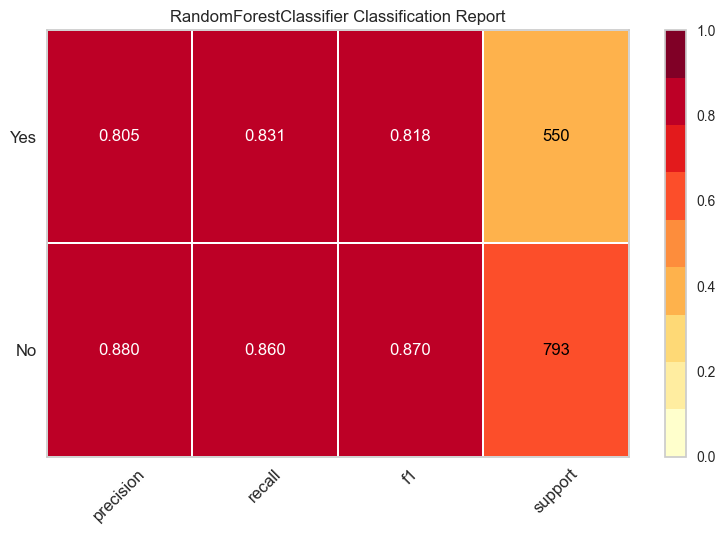

ClassificationReport(ax=<Axes: title={'center': 'RandomForestClassifier Classification Report'}>,
                     classes=['No', 'Yes'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000024E401B6510>,
                     estimator=RandomForestClassifier(max_features=8,
                                                      n_estimators=1000,
                                                      n_jobs=-2, oob_score=True,
                                                      random_state=1),
                     support=True)

In [109]:

classification_report(rfc, X_train, y_train, X_test, y_test, classes=["No", "Yes"], support=True)

In [131]:
y_train.describe()

,subscription
count,6266.000000
mean,0.416693
std,0.493050
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


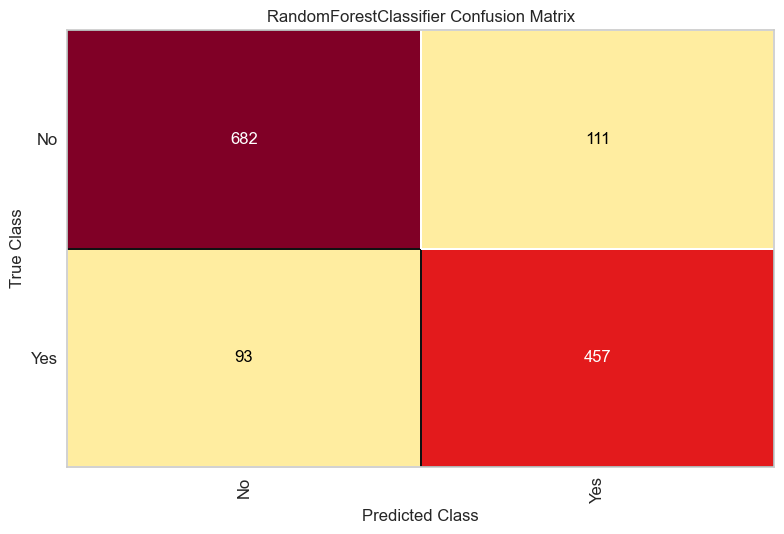

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['No', 'Yes'],
                cmap=<matplotlib.colors.ListedColormap object at 0x0000024E3E47CD50>,
                estimator=RandomForestClassifier(max_features=8,
                                                 n_estimators=1000, n_jobs=-2,
                                                 oob_score=True,
                                                 random_state=1))

In [133]:

confusion_matrix(rfc, X_train, y_train, X_test, y_test, classes=["No", "Yes"], percent=False)

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


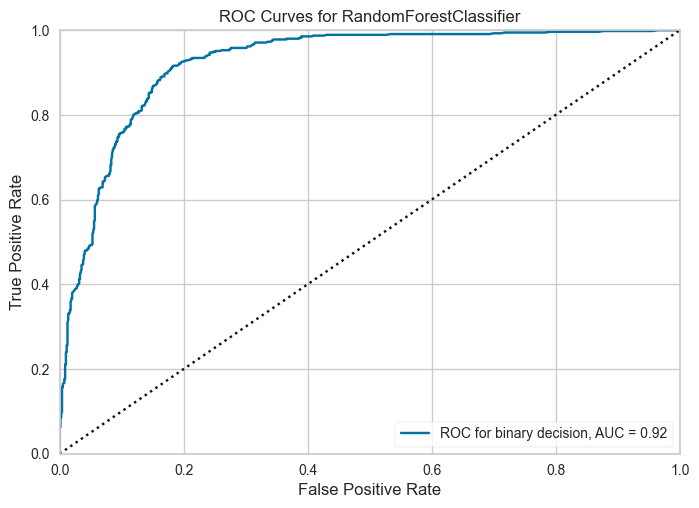

In [112]:

y_train_lab = LabelEncoder().fit_transform(y_train)
y_test_lab = LabelEncoder().fit_transform(y_test)

roc_auc(rfc, X_train, y_train_lab, X_test=X_test, y_test=y_test_lab, classes=["No", "Yes"], 
        micro=False, macro=False, per_class=False);

In [113]:
from sklearn.metrics import roc_curve
p_hat = rfc.predict_proba(X_test)
p_hat
fpr, tpr, thresholds = roc_curve(y_test_lab, p_hat[:, 1])

In [37]:
fpr
tpr
thresholds

array([1.980e+00, 9.800e-01, 9.620e-01, 9.615e-01, 9.550e-01, 9.540e-01,
       9.495e-01, 9.485e-01, 9.480e-01, 9.475e-01, 9.460e-01, 9.455e-01,
       9.425e-01, 9.420e-01, 9.405e-01, 9.390e-01, 9.380e-01, 9.370e-01,
       9.365e-01, 9.300e-01, 9.265e-01, 9.255e-01, 9.245e-01, 9.240e-01,
       9.195e-01, 9.155e-01, 9.145e-01, 9.130e-01, 9.120e-01, 9.080e-01,
       9.070e-01, 9.030e-01, 9.025e-01, 8.990e-01, 8.985e-01, 8.955e-01,
       8.890e-01, 8.880e-01, 8.870e-01, 8.860e-01, 8.855e-01, 8.850e-01,
       8.830e-01, 8.790e-01, 8.780e-01, 8.775e-01, 8.770e-01, 8.730e-01,
       8.720e-01, 8.710e-01, 8.700e-01, 8.650e-01, 8.635e-01, 8.605e-01,
       8.585e-01, 8.575e-01, 8.570e-01, 8.565e-01, 8.545e-01, 8.530e-01,
       8.525e-01, 8.510e-01, 8.465e-01, 8.460e-01, 8.435e-01, 8.400e-01,
       8.390e-01, 8.385e-01, 8.375e-01, 8.345e-01, 8.340e-01, 8.330e-01,
       8.325e-01, 8.310e-01, 8.300e-01, 8.280e-01, 8.265e-01, 8.260e-01,
       8.235e-01, 8.230e-01, 8.175e-01, 8.170e-01, 

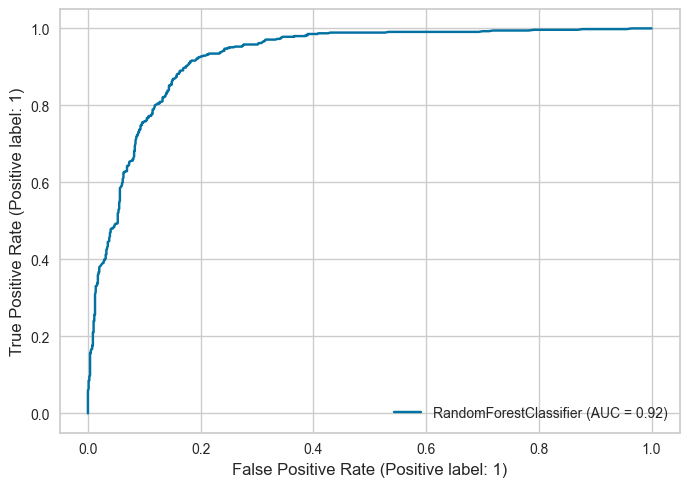

In [114]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc, X_test, y_test_lab)